In [1]:
%matplotlib inline
import numpy as np
import tensorflow as tf
import seaborn as sns
import pandas as pd
import matplotlib as mpl
import IPython.display as ipd
import sklearn as sk

In [2]:
data = pd.read_csv('datasets/bikesharing-hour.csv', index_col=0)

In [3]:
data.dteda = pd.to_datetime(data.dteday, format='%Y-%m-%d').dt.normalize()
data.season = data.season.astype('category')
data.mnth = data.mnth.astype('category')
data.hr = data.hr.astype('category')
data.holiday = data.holiday.astype(bool)
data.weekday = data.weekday.astype('category')
data.workingday = data.workingday.astype(bool)
data.weathersit = data.weathersit.astype('category')

/home/mcc/danielramos/.pyenv/versions/anaconda3-5.3.0/envs/CKP8277/lib/python3.6/site-packages/ipykernel_launcher.py:1: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  """Entry point for launching an IPython kernel.


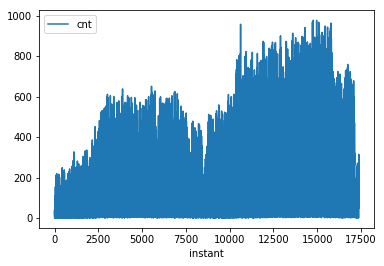

In [4]:
data.plot.line(y='cnt')